## Problem Statement: 
Build a generic tool that can scrpae user comments from a specific subreddit that talks about health symptoms. After scraping, perform sentiment analysis to understand where the users' stand in terms of clinical trials - whether they're willing to try, or have had negative experience, or just have a neutral standpoint. After getting the sentiment, create a custom message for each user using OpenAI API.

In [336]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [185]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [186]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [187]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [339]:
#All the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import praw
import re
import emoji
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
import openai

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/divyahegde/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/divyahegde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/divyahegde/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## SUBSTITUTE VALUES FROM GDOC HERE

In [ ]:
OPENAI_API_KEY = ''
CLIENT_ID = ''
CLIENT_SECRET = ''
USERNAME = ''
PASSWORD = ''

In [340]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Web-scraping using PRAW library

In [341]:
#Setting up reddit instance along with client ID and secret of the app on reddit side
reddit = praw.Reddit(
    client_id = CLIENT_ID,
    client_secret = CLIENT_SECRET,
    user_agent='Clinical Trails Scraping',
    username = USERNAME,
    password = PASSWORD
)

In [342]:
def scrape_data(subreddit, limit = 100):
    comments = []
    posts = []
    i = 0

    subreddit = reddit.subreddit(subreddit)
    # Fetch top posts from the subreddit
    for post in subreddit.top(limit=100):
        posts.append({
                'title': post.title,
                'description': post.selftext,
                'upvotes' : post.ups
            })
        # Fetch comments
        post.comments.replace_more(limit=0)  # This line ensures all comments are loaded
        for comment in post.comments.list():
            
            comments.append({
                    'title': i,
                    'user' : comment.author.name if comment.author is not None else None,
                    'comment': comment.body
                })
        
        i = i+1
    return pd.DataFrame(posts), pd.DataFrame(comments) 



Using the subredddit 'Cancer' as I think it has a lot of ongoing discussions and clinical trials. The scraping function essentially return two dataframes - one with the main post title and description, other one which holds the mapping of the main post and the comments/discussions along with user Ids.

In [343]:
raw_data_posts, raw_data_comments = scrape_data('cancer',100)

In [344]:
raw_data_posts.head()

,title,description,upvotes
0,I’m not ready.,In 2016 I was diagnosed with stage 4 of a seve...,1257
1,I’m happy to tell you guys that I have been tw...,,1065
2,Today is the Day After - Resectioning Surgery ...,,1039
3,"I’ve got 2-4 weeks to live, we’re in the end g...",Hey everyone you might have seen my post on he...,992
4,My daughter rang the chemo bell yesterday!,She is only 3 and being pinned down for weekly...,885


In [345]:
raw_data_comments.head()

,title,user,comment
0,0,cdnirene,You won’t be forgotten. I lost my best friend ...
1,0,None,Have you thought about making a video and leav...
2,0,doodlewithcats,This left me speechless. I’m just so sorry bec...
3,0,MostMender,"Damn, that is just so sad, i'm living with dep..."
4,0,codecowboy,I'm so sorry you are going through this. My w...


In [346]:
pattern = '|'.join([re.escape(keyword) for keyword in keywords])
raw_data_comments['contains_keyword'] = raw_data_comments['comment'].str.contains(pattern, flags=re.IGNORECASE, na=False)


In [347]:
raw_data_posts.shape

(100, 3)

In [348]:
raw_data_comments.shape

(6204, 4)

In [349]:
raw_data_comments['title'].nunique()

100

In [350]:
grouped_comments = raw_data_comments.groupby(['title', 'user']).agg(comment_count=('user', 'count')).reset_index()

print(grouped_comments)

      title                user  comment_count
0         0              105386              1
1         0             10vlone              1
2         0       AkkalaTechLab              1
3         0          Aperture45              1
4         0            Blazing1              1
...     ...                 ...            ...
4012     99           murkymist              1
4013     99  panoramicambitions              1
4014     99         princesszxn              1
4015     99        sanpaccrisps              1
4016     99        thefifthboss              1

[4017 rows x 3 columns]


dropping comments that were deleted. This is usually denoted by [deleted] in string

In [351]:
deleted_comments = raw_data_comments[raw_data_comments['comment'] == '[deleted]'].index
raw_data_comments = raw_data_comments.drop(deleted_comments)

### Let's clean text

In [352]:
# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

Since we are tasked with finding sentiment of users, it is important that we preserve the negating words when removing the stopwords in pre-processing step. It provides the more accuracy and reflects the correct sentiment.

In [353]:
negations = [
    'not', 'no', 'none', 'neither', 'never', 'nobody', 'nothing', 'nowhere',
    'isn\'t', 'aren\'t', 'wasn\'t', 'weren\'t', 'doesn\'t', 'don\'t', 'didn\'t',
    'cannot', 'can\'t', 'couldn\'t', 'shouldn\'t', 'wouldn\'t',
    'haven\'t', 'hasn\'t', 'hadn\'t', 'won\'t'
]

# keeping everything from the stop words except the negations list
stop_words = stop_words.difference(negations) 

In [354]:
def clean_text(text):
    
    #Changing to lowerecase
    text = text.lower()
    # Removing URLs
    text = re.sub(r'http\S+', '', text)
    #Reoving emoji
    text = emoji.replace_emoji(text, replace='')
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Replace numbers with nothing
    text = re.sub(r'\d+', '', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Lemmatization and stop words removal
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [355]:
raw_data_comments['cleaned_comments'] = raw_data_comments['comment'].apply(clean_text)

In [356]:
raw_data_comments.head(20)

,title,user,comment,contains_keyword,cleaned_comments
0,0,cdnirene,You won’t be forgotten. I lost my best friend ...,False,forgotten lost best friend teenager decade lat...
1,0,None,Have you thought about making a video and leav...,False,thought making video leaving mum perhaps young...
2,0,doodlewithcats,This left me speechless. I’m just so sorry bec...,False,left speechless sorry not fair no word really ...
3,0,MostMender,"Damn, that is just so sad, i'm living with dep...",False,damn sad living depression thought suicide say...
4,0,codecowboy,I'm so sorry you are going through this. My w...,False,sorry going wife battling terminal cancer righ...
5,0,deliciousbirdthe3rd,Hey my best friend passed away from brain canc...,False,hey best friend passed away brain cancer far y...
6,0,Total_Dick_Move,"I’m so sorry. But, sweetie, nobody will forget...",False,sorry sweetie nobody forget nobody perhaps jou...
7,0,treecookie,"It's just so shitty, I'm so sorry.\n\nI have a...",False,shitty sorry seven month old daughter currentl...
8,0,Krumple_Footskin,It's easy to see how much you love your family...,False,easy see much love family post sorry go honest...
9,0,lap3,I lost my best friend to Ewing’s at 22. Videos...,False,lost best friend ewing video keep going lucky ...


## Keywords related to clinical trials

The approach I have taken here is make a list of keywords that are most likely to appear in a conversation about clinical trials. Why is this needed?

- This is not a straight sentiment analysis. We need to figure out the sentiment of a user regarding clinical trials.
- After having figured out the overall sentiment of the comment, we see if the comment has any of the keywords. 

I have used TextBlob and VADER here. I'm sticking to VADER as its meant for analysing sentiments for social media.

In [357]:
keywords = [
    'clinical trial', 'study participation', 'placebo', 'double-blind',
    'informed consent', 'trial phase', 'ethics', 'recruitment', 'randomized',
    'intervention', 'effective', 'efficacy', 'risks', 'benefits', 'treatment', 'drug',
    'volunteer', 'participant',  'innovation', 'breakthrough',
    'enroll', 'participate', 'study', 'control group', 'interested in participating', 'research'
]


In [358]:
raw_data_comments[raw_data_comments['contains_keyword'] == True]

,title,user,comment,contains_keyword,cleaned_comments
605,6,theyreall_throwaways,You prob already have a good arsenal of foods ...,True,prob already good arsenal food supplement like...
613,6,theyreall_throwaways,"I understand your point, and no one should eve...",True,understand point no one ever think person beat...
692,8,M_B3516,Praying for God’s divine intervention. He alon...,True,praying god divine intervention alone determin...
732,8,pete_sauce,The first year through the main regiment of tr...,True,first year main regiment treatment hard mostly...
983,12,Ohm_My_God,"Aw, man. This really hurts.\n\nLooks like I'm ...",True,aw man really hurt look like not going terribl...
1047,12,shailt,Thank you. My daughter goes to a college at So...,True,thank daughter go college southern california ...
1485,17,innout_forever_yum,I’m 6-9 months behind you with stage iv cholan...,True,month behind stage iv cholangiocarcinoma start...
1506,17,Sea_Map9327,"I’m so sorry, it’s so shitty. \n\nResponding t...",True,sorry shitty responding last line national can...
1549,17,elee419,Just in case you haven’t explored this option ...,True,case explored option cldn car clinical trial c...
1583,17,rcavictorman57,I actually have tried Fenbendazole. Absorption...,True,actually tried fenbendazole absorption issue p...


In [359]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    interest = any(keyword in text.lower() for keyword in keywords)
    
    if interest and sentiment > 0:
        return 'positive'
    elif interest and sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

In [360]:
raw_data_comments['sentiment'] = raw_data_comments['cleaned_comments'].apply(analyze_sentiment)

In [361]:
raw_data_comments.head(20)

,title,user,comment,contains_keyword,cleaned_comments,sentiment
0,0,cdnirene,You won’t be forgotten. I lost my best friend ...,False,forgotten lost best friend teenager decade lat...,neutral
1,0,None,Have you thought about making a video and leav...,False,thought making video leaving mum perhaps young...,neutral
2,0,doodlewithcats,This left me speechless. I’m just so sorry bec...,False,left speechless sorry not fair no word really ...,neutral
3,0,MostMender,"Damn, that is just so sad, i'm living with dep...",False,damn sad living depression thought suicide say...,neutral
4,0,codecowboy,I'm so sorry you are going through this. My w...,False,sorry going wife battling terminal cancer righ...,neutral
5,0,deliciousbirdthe3rd,Hey my best friend passed away from brain canc...,False,hey best friend passed away brain cancer far y...,neutral
6,0,Total_Dick_Move,"I’m so sorry. But, sweetie, nobody will forget...",False,sorry sweetie nobody forget nobody perhaps jou...,neutral
7,0,treecookie,"It's just so shitty, I'm so sorry.\n\nI have a...",False,shitty sorry seven month old daughter currentl...,neutral
8,0,Krumple_Footskin,It's easy to see how much you love your family...,False,easy see much love family post sorry go honest...,neutral
9,0,lap3,I lost my best friend to Ewing’s at 22. Videos...,False,lost best friend ewing video keep going lucky ...,positive


In [362]:
#raw_data_comments.to_csv('sentiment_result.csv')

### Visualising wordcloud of common words in postitive sentiment comments

In [363]:
positive_comments = raw_data_comments[raw_data_comments['sentiment'] == 'positive']['cleaned_comments'].str.cat(sep=' ')

In [364]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_comments)

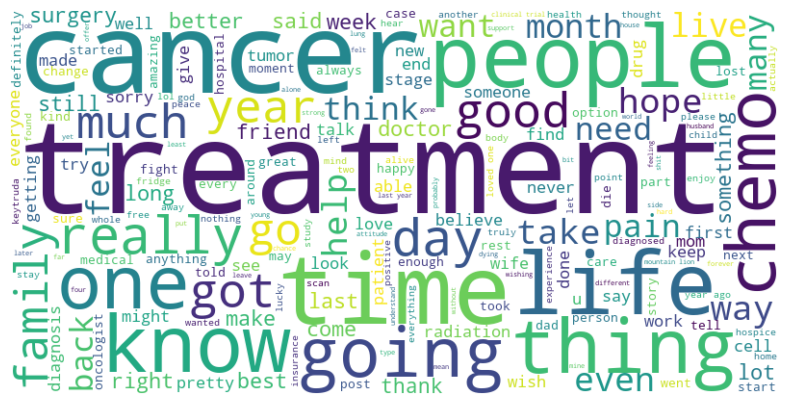

In [365]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Visualising wordcloud of common words in negative sentiment comments

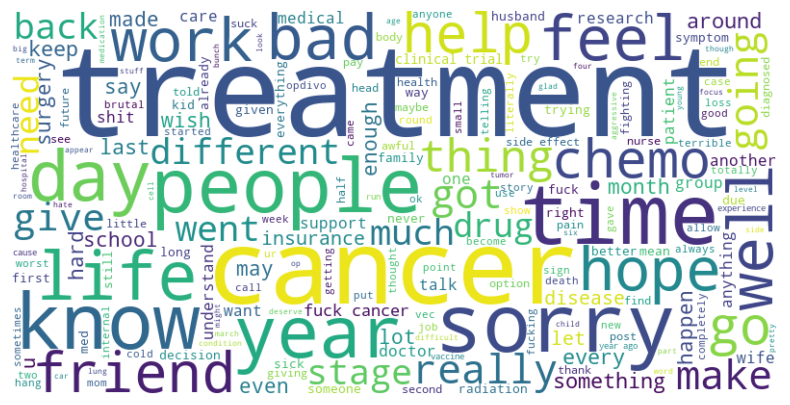

In [366]:
negative_comments = raw_data_comments[raw_data_comments['sentiment'] == 'negative']['cleaned_comments'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [367]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
from collections import Counter

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/divyahegde/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


As mentioned earlier, I'm also using VADER to understand the sentiment score. The below function computes a weighted sentiment score like so:
- Analyzing the overall sentiment of the text.
- Counting the occurrences of specific keywords in the text.
- Calculating a weighted sum of these counts multiplied by the overall sentiment score.
- Normalizing this weighted sum by the total count of keyword appearances to prevent bias towards longer texts.
- Returning the normalized weighted sentiment score.

In [368]:
def weighted_sentiment(text):
    # Analyze the sentiment of the text
    sentiment_score = sia.polarity_scores(text)['compound']

    # Count the frequency of each allowed keyword in the text
    word_counts = Counter(word.lower() for word in text.split() if word.lower() in keywords)

    # Calculate the weighted sentiment sum: multiply each word's count by the overall sentiment score and sum them
    weighted_sum = sum(count * sentiment_score for word, count in word_counts.items())
    
    # Normalize by the total count of keyword appearances to prevent bias towards longer texts
    total_keywords = sum(word_counts.values())
    weighted_average = weighted_sum / total_keywords if total_keywords > 0 else 0
    
    return weighted_average

In [369]:
raw_data_comments['score'] = raw_data_comments['cleaned_comments'].apply(weighted_sentiment)

## OpenAI API 

In [370]:
import openai
from openai import OpenAI

client = OpenAI(
  api_key = OPENAI_API_KEY)

In [371]:
def generate_response(text, is_positive):
    prompt = ""
    if is_positive:
        prompt = f"Write a persuasive response encouraging someone to participate in a clinical trial based on the comment: '{text}'"
    else:
        prompt = f"Write a response addressing concerns based on this negative feedback about a clinical trial: '{text}'"
    
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You will be given a comment from a user, after understanding the content of the text, generate custom message for participation in clinical trial. Keep it less than 75 words"},
        {"role": "user", "content": text}
      ]  
    )

    return response.choices[0].message.content

In [372]:
raw_data_comments['Response'] = raw_data_comments.apply(
    lambda row: generate_response(row['comment'], row['score'] > 0) if row['score'] != 0 else None, 
    axis=1
)

Let's see an example of positive sentiment and see what response is generated.

In [373]:
generate_response("The first year through the main regiment of treatment was very hard, mostly focusing on getting through chemotherapy.After that the quality of my life got way better. I was able to go back to university, travel, hold jobs, enjoy time with loved ones. Live a pretty normal life.Once I relapsed things got hard again, the surgery I had came close to killing me. But eventually once I recovered the palliative treatment was effective enough that I was still able to do a lot of the things I love!I definitely dont regret receiving all the treatment regardless of its ill effects.", True)

'Your journey through treatment showcases incredible resilience and determination. Your positive attitude and willingness to keep fighting is truly inspiring. Consider participating in a clinical trial to continue making a difference in cancer research and potentially help others in similar situations. Your experience and feedback could be invaluable in shaping the future of cancer treatment. Keep shining bright!'

In [374]:
raw_data_comments[raw_data_comments['score'] < 0]

,title,user,comment,contains_keyword,cleaned_comments,sentiment,score,Response
539,5,Oopiku,I would not have gotten through treatment as w...,False,would not gotten treatment well without puppy ...,neutral,-0.4717,Your furry companion sounds like a wonderful s...
603,6,doveenigma13,"If you ask, they will tell you the studies per...",False,ask tell study percentage patient similar cancer,neutral,-0.6597,Learn more about your cancer and potential tre...
613,6,theyreall_throwaways,"I understand your point, and no one should eve...",True,understand point no one ever think person beat...,positive,-0.5759,"Absolutely, having a positive attitude can con..."
615,6,letmeseem,But I mean the survival rate is in itself usel...,False,mean survival rate useless part wood press giv...,negative,-0.8919,Understand your concerns about survival rates....
618,6,angryhaiku,That's really good news! The numbers they give...,False,really good news number give little outdated t...,positive,-0.0853,It's great to hear about your proactive approa...
811,9,oxfoodoo233,Wishing you peace. \nAnd if anyone tired of l...,False,wishing peace anyone tired long wait medical t...,positive,-0.4767,Thank you for sharing this information. If you...
1014,12,new_to_here,I have synovial sarcoma and my prognosis is de...,False,synovial sarcoma prognosis decent sent tailspi...,negative,-0.5719,We admire your strength and resilience in the ...
1155,13,oxfoodoo233,**I hope you get better soon！**\r \nAnd if an...,False,hope get better soon anyone tired long wait me...,positive,-0.4019,Join our clinical trial for a chance to receiv...
1357,15,None,"I had a mole appear out of nowhere, Nodular me...",False,mole appear nowhere nodular melanoma wle two y...,negative,-0.7880,I appreciate your strength and resilience thro...
1366,15,None,The recurrence was in a lymph node behind my e...,False,recurrence lymph node behind ear super visible...,negative,-0.7420,We are inspired by your strength and resilienc...


In [375]:
raw_data_comments.to_csv('sentiment_result.csv')

## How did this whole approach perform?

In [379]:
postive_responses = raw_data_comments[raw_data_comments['score'] > 0][['comment', 'Response']]

In [384]:
negative_responses = raw_data_comments[raw_data_comments['score'] < 0][['comment', 'Response']]

In [382]:
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_rows', None) 

In [383]:
postive_responses.head(20)

,comment,Response
9,"I lost my best friend to Ewing’s at 22. Videos of him keep me going. We’re lucky (at times) to live in a world with technology that enables our memory to live on forever. He was given NED after treatment and four months later had a PET scan because he was having migraines and one day woke up not knowing who he was. The cancer was back, and everywhere. They said he had 4 weeks left to live in April. He died in October that year. He did everything he ever wanted to and we all helped him (go to the super bowl, cross country road trips, music festivals on opposite coasts). I cry anytime I hear of any situation such as yours because I was the best friend. But I want you to know that you will not be forgotten and fade away. I loved my best friend, and I share an immense love toward you, essentially a total stranger, because I listened to him say exactly what you’re saying. I don’t know if this post will seem appropriate or make much sense, but as someone on the other side of this insidious disease, I want you to KNOW you’re forever loved- today, tomorrow, months, and years from now. \n\nMy own best friend didn’t tell any of us when he began hospice, and we didn’t know until an hour after it happened. I never got to say my goodbyes and it’s something that haunts me every day. Everyone goes their own way but it was devastating and debilitated me for months. They want to be there for you. I’m crying as I write this. I don’t know what this whole post means, maybe perspective? I don’t want to offend you. Just again, PLEASE know how strong you are, and how you have changed your loved ones lives for the better just by existing. They will get better as time passes and be shaped by you, just as I am by my Mitch that is gone. I love you and please know you will not be forgotten and forever loved.","Your heartfelt message is a reminder of the deep impact loved ones with Ewing’s have on those around them. Your experiences emphasize the importance of cherishing moments and sharing love. We invite you to consider joining a clinical trial to honor your friend's memory by contributing to advancements in Ewing’s research. Your strength and compassion can make a difference in the lives of others facing similar challenges. Stay resilient, your love and support are truly powerful."
38,"This seriously breaks my heart and is so haunting to me. I was treated for Ewing's last year and I have entertained this scenario many, many times. I'm a bit older than you, but I think it's actually harder to wrap your head around dying when you're younger. All that I can say is take deep, long breaths when you're with the people you love and doing the things you enjoy. In those moment to savor every single moment of them. \n\nA realization that I had during treatment is that up until that point, there were so many moments in my recent life (I was finishing up college) where I was not living in the moment and thinking about the past or the future. That made the time go by so fast and I was left unfulfilled. It was so painful to think about when I also thought I was not going to survive (earlier on and then during a first post-chemo scans scare) because I was trying to grasp onto the moments that I cherished and that there really were no recent ones. A lot of people have these realizations after a lifetime of moments and have the same feeling. \n\nI also started writing a lot more to get my feelings on the page. I highly suggest this if you think your siblings won't remember you. They will change and their understanding of you will change, but they can always come back to your words and that will be the most personal way of communication. It'll almost be like your speaking directly to them. They can interpret it in new ways as they get older and develop more of an appreciation for you. It's like a book that you can read a million times and never get tired of because it connects to you. I really think this will help!",Your journey with Ewing's is trul

In [385]:
negative_responses.head(20)

,comment,Response
539,I would not have gotten through treatment as well as I did without my puppy there to support me.,Your furry companion sounds like a wonderful source of comfort during your treatment. Your experience highlights the importance of emotional support in difficult times. Consider participating in a clinical trial where you can potentially help others facing similar challenges. Your story could inspire hope and pave the way for advancements in medical research.
603,"If you ask, they will tell you the studies percentage of other patients with similar cancers.",Learn more about your cancer and potential treatment options by participating in a clinical trial. Be empowered with information specific to your condition. Join now to contribute to medical research and explore innovative therapies. Your participation could make a difference.
613,"I understand your point, and no one should ever think that a person didn't beat cancer because of the 'wrong' attitude. That is an insane and hurtful way of thinking. \n\nThat being said, attitude is extremely important in all aspects of health. There have been many repeated, large sample size scientific studies showing that a positive attitude does effect physical well being and outcome. Of course, just because it's important doesn't mean it's the only variable. It's similar to the way that placebo and nocebo effects work. Your mind is extremely important in health outcomes and we are beginning to understand this more and more. But like all things, it plays its part but isn't the only factor. A positive attitude won't heal your broken bone or cure your cancer, but it's an important factor and shouldn't be dismissed.","Absolutely, having a positive attitude can contribute to overall well-being. Your insights on the mind-body connection are valuable. If you are open to further exploring this relationship, you may consider participating in our clinical trial evaluating the impact of mindset on health outcomes. Your perspective could help advance our understanding of these connections. Your participation could make a meaningful difference."
615,"But I mean the survival rate is in itself useless. In my part of the woods if you press for it they'll give a general survival at 1, 3 and or 5 years, but will be very clear it's not my (or your) chance of survival. \n\nThose rates include severely overweight people, people with other conditions, history of alcohol and drug abuse, different ages and so on and so on.. All setting their starting point at a different level. A survival rate at 11% doesn't say anything about your specific case. It doesn't even give you a hint.","Understand your concerns about survival rates. However, participating in a clinical trial can provide personalized treatment and access to cutting-edge therapies tailored to your specific condition and needs. Your unique case will be closely monitored, offering a chance to potentially benefit from advancements in medical research and improving outcomes. Your participation could make a difference not only for you but for others facing similar challenges."
618,"That's really good news! The numbers they give you are a little outdated -- treatments have gotten somewhat better since they did the studies that collected the numbers, but I do think it's responsible of your doctors that they gave you the moderate-case scenario. I'm sorry to hear about your foot! But the farther away from your lungs the primary site is, the lower the chances of metastases. \n\n\nI got my treatment at the Arizona Cancer Center, and I also felt that it was very good; people will tell you that you HAVE to be at Mayo or Cedars-Sinai, and it's just not true -- there are really skilled oncologists around the country, and if you trust your team, that's what matters. \n\n\nDON'T go vegan. I actually had been a vegetarian for many years before I got sick, and the Cancer Center's dietitian basically told me ""Look, if you don't start getting more protein, yo

I was able to generate custom messages for positive and negative sentiments (268 in total). Most of the sentiment was predicted to be neutral.
While some of the sentiment predictions make sense, some of the ones precited as negative by VADER seem to be incorrect. 
On the whole, the custom generated messages seem to do a good job (although a small proportion compared to the entire dataframe)